<a href="https://colab.research.google.com/github/Rodiat/FDSfE_RAyinde/blob/main/HW7/FDSfE_NLP_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis of Movie Reviews:
## Data - 
the data comes from the Kaggla challenge https://www.kaggle.com/code/yagli18/sentiment-analysis-on-movie-reviews and is comprosed of ~10k movie reviews and associated ratings. 
The challenge there is to create a model that predicts the rating based on the review, which is a Natural Language Processing sentiment analysis task. Sentiment analysis measures the "sentiment" (typically in a positive-to-negative linear scale) of a text. There are many issues with sentiment analysis in genera, and in particulat here, the "sentiment" of the review (negative, which is associated with sad and angry for example) may not match with the judgement on the quality of the movie (which may be sad, but good if it is a drama) 

**We will simply apply a pre-trained model that weights each word in the text to measure its negative-to-positive sentiment and compounds all the words to get an overall sentiment. The right way to do this tho would be to _train_ a new model on the data, learning the match between the sentiment of the words and the rating assigned by the author of the review. That way, the model is _specific_ to this data. This is a challenge that I live for you!**

In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install stop_words

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32912 sha256=af8306243dba80630abfc8c9b24fa299907d26cf08645fe6aa41e28162b56737
  Stored in directory: /root/.cache/pip/wheels/fb/86/b2/277b10b1ce9f73ce15059bf6975d4547cc4ec3feeb651978e9
Successfully built stop-words


In [3]:
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 4.8 MB/s 


In [53]:
import os
import json
import pandas as pd

import numpy as np
import pylab as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import statistics as st

In [5]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [6]:
cd /content/drive/MyDrive/

/content/drive/MyDrive


In [7]:
env = json.load(open("kaggle.json", "r"))
os.environ["KAGGLE_USERNAME"] = env["username"]
os.environ["KAGGLE_KEY"] = env["key"]

In [8]:
!kaggle datasets sentiment

usage: kaggle datasets [-h]
                       {list,files,download,create,version,init,metadata,status}
                       ...
kaggle datasets: error: argument command: invalid choice: 'sentiment' (choose from 'list', 'files', 'download', 'create', 'version', 'init', 'metadata', 'status')


In [9]:
!mkdir sentimentanalysis

mkdir: cannot create directory ‘sentimentanalysis’: File exists


In [10]:
cd sentimentanalysis/

/content/drive/MyDrive/sentimentanalysis


In [11]:
!kaggle competitions download -c sentiment-analysis-on-movie-reviews

sentiment-analysis-on-movie-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [12]:
!ls *

sampleSubmission.csv			 test.tsv.zip
sentiment-analysis-on-movie-reviews.zip  train.tsv.zip


In [13]:
!unzip  sentiment-analysis-on-movie-reviews.zip


Archive:  sentiment-analysis-on-movie-reviews.zip
replace sampleSubmission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [14]:
reviews = pd.read_csv("train.tsv.zip", sep="\t")
reviews

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
...,...,...,...,...
156055,156056,8544,Hearst 's,2
156056,156057,8544,forced avuncular chortles,1
156057,156058,8544,avuncular chortles,3
156058,156059,8544,avuncular,2


In [15]:
reviews = reviews.groupby("SentenceId").first()
reviews

,PhraseId,Phrase,Sentiment
SentenceId,,,
1,1,A series of escapades demonstrating the adage ...,1
2,64,"This quiet , introspective and entertaining in...",4
3,82,"Even fans of Ismail Merchant 's work , I suspe...",1
4,117,A positively thrilling combination of ethnogra...,3
5,157,Aggressive self-glorification and a manipulati...,1
...,...,...,...
8540,155985,... either you 're willing to go with this cla...,2
8541,155998,"Despite these annoyances , the capable Claybur...",2
8542,156022,-LRB- Tries -RRB- to parody a genre that 's al...,1


In [16]:
reviews.shape

(8529, 3)

In [17]:
reviews[["Phrase", "Sentiment"]].values

array([['A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .',
        1],
       ['This quiet , introspective and entertaining independent is worth seeking .',
        4],
       ["Even fans of Ismail Merchant 's work , I suspect , would have a hard time sitting through this one .",
        1],
       ...,
       ["-LRB- Tries -RRB- to parody a genre that 's already a joke in the United States .",
        1],
       ["The movie 's downfall is to substitute plot for personality .",
        1],
       ["The film is darkly atmospheric , with Herrmann quietly suggesting the sadness and obsession beneath Hearst 's forced avuncular chortles .",
        2]], dtype=object)

In [18]:
print('Number of Reviews/Documents: {}'.format(len(reviews)))

print('Corpus Size (words): {}'.format(np.sum([len(phrase.split()) for phrase in reviews["Phrase"].values])))

Number of Reviews/Documents: 8529
Corpus Size (words): 162044


In [19]:
reviews.Sentiment.unique()

array([1, 4, 3, 2, 0])

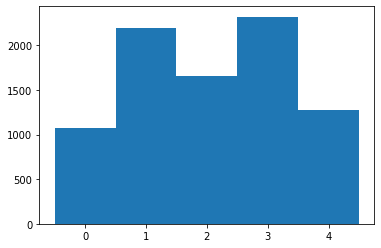

In [20]:
#plot sentiment histogram
plt.hist(reviews["Sentiment"], bins=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5]);

In [21]:
!python -m nltk.downloader punkt

/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [22]:
#NLP packs
#import nltk  --> used in this notebook
#from nltk.tokenize import word_tokenize --> used in this notebook
#from nltk.corpus import stopwords
#from stop_words import get_stop_words --> used in this notebook
#from textblob import TextBlob , Word
#import re 
#import string

In [23]:
#remove some characters like new line from the strings
reviews['Phrase'] = reviews['Phrase'].str.lower(
    ).str.replace(
        '[^\w\s]', '').str.replace(
            '\d+', '').str.replace(
                '\n',' ').replace(
                        '\r','').str.replace(
                            "[^a-zA-Z0-9\s]",'') 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  


# lets talk about the lambda construct and apply

In [24]:
reviews['Phrase'] = reviews['Phrase'].apply(lambda x: word_tokenize(x)) # sentence -> words
reviews['Phrase']

SentenceId
1       [a, series, of, escapades, demonstrating, the,...
2       [this, quiet, introspective, and, entertaining...
3       [even, fans, of, ismail, merchant, s, work, i,...
4       [a, positively, thrilling, combination, of, et...
5       [aggressive, selfglorification, and, a, manipu...
                              ...                        
8540    [either, you, re, willing, to, go, with, this,...
8541    [despite, these, annoyances, the, capable, cla...
8542    [lrb, tries, rrb, to, parody, a, genre, that, ...
8543    [the, movie, s, downfall, is, to, substitute, ...
8544    [the, film, is, darkly, atmospheric, with, her...
Name: Phrase, Length: 8529, dtype: object

# lets talk about stop words... and list comprehensions

In [25]:
STOPWORDS

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'all',
 'also',
 'am',
 'an',
 'and',
 'any',
 'are',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 "can't",
 'cannot',
 'com',
 'could',
 "couldn't",
 'did',
 "didn't",
 'do',
 'does',
 "doesn't",
 'doing',
 "don't",
 'down',
 'during',
 'each',
 'else',
 'ever',
 'few',
 'for',
 'from',
 'further',
 'get',
 'had',
 "hadn't",
 'has',
 "hasn't",
 'have',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'hence',
 'her',
 'here',
 "here's",
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 "how's",
 'however',
 'http',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'k',
 "let's",
 'like',
 'me',
 'more',
 'most',
 "mustn't",
 'my',
 'myself',
 'no',
 'nor',
 'not',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'otherwise',
 'ought',
 'our',
 

In [26]:
reviews["Phrase"] = reviews["Phrase"].apply(lambda x: [word for word in x if word not in STOPWORDS]) # stop words removal


# Frequency of words

In [27]:
nltk.FreqDist(reviews.Phrase.sum()).most_common(10)

[('s', 2558),
 ('film', 1150),
 ('movie', 969),
 ('nt', 680),
 ('one', 553),
 ('rrb', 352),
 ('lrb', 351),
 ('story', 347),
 ('will', 265),
 ('good', 264)]

In [28]:
#reviews["Phrase"] = reviews["Phrase"].apply(lambda x : 
#                  [word for word in x if word not in 
#                   ["s", "nt", "rrb", "lrb", "one"]]) # more "stop" words 
# or I could do it by length: are there gpoing to be key words that are <4 characters??
reviews["Phrase"] = reviews["Phrase"].apply(lambda x : 
                  [word for word in x if len(word)>3]) # more "stop" words 


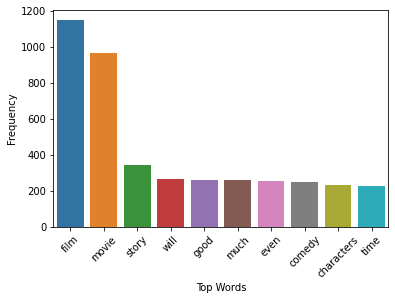

In [29]:
words_freq = pd.DataFrame(nltk.FreqDist(reviews.Phrase.sum(
                                          )).most_common(10), 
                          columns=['Top Words', 'Frequency'])
ax = sns.barplot(x="Top Words",y="Frequency",data=words_freq)
plt.xticks(rotation = 45); # Rotates X-Axis Ticks by 45-degrees


# Lets talk about the str.join() method

In [30]:
def wc(data,bgcolor): # word cloud
    plt.figure(figsize=(10,10))
    wc = WordCloud(background_color=bgcolor, max_words=100, 
                 min_word_length=4, contour_width=3, 
                 contour_color='steelblue')
    wc.generate(" ".join(data)) # tum kelimeleri birlestirip tek 1 string haline getirir
    plt.imshow(wc)
    plt.axis("off")


#TASK 1 : 
Use the function above to plot the word cloud **for Sentiment==0**, comment on the plot to describe how a wordcloud should be read and what are interesting words that appear

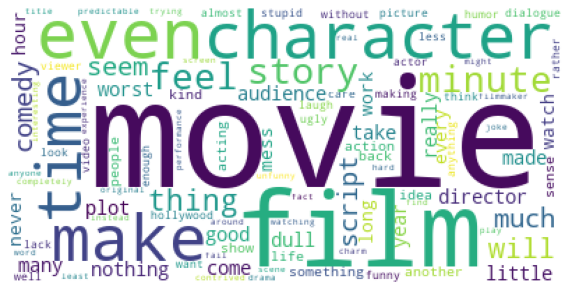

In [31]:
# your code here
#plot the word cloud for sentiment 0
wc(reviews[reviews["Sentiment"]==0]["Phrase"].sum(), bgcolor="white")

This figure utilizes a function to look at the first 100 words that are in the Phrase column with a sentiment of zero and creates a word cloud that makes the size of the word proportional to how frequently the word appears. Some interesting words include "stupid", "worst", "dull", and "predictable".

#TASK 2 : 
Use the function above to plot the word cloud **for Sentiment==4**, comment on the plot to describe how a wordcloud should be read and what are interesting words that appear. How does it differ from Sentiment==0?

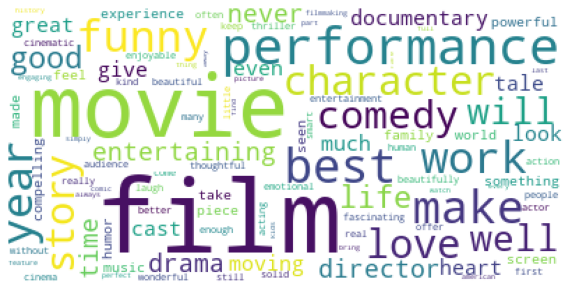

In [32]:
# your code here
#plot the word cloud for sentiment 4
wc(reviews[reviews["Sentiment"]==4]["Phrase"].sum(), bgcolor="white")

This figure utilizes a function to look at the first 100 words that are in the Phrase column with a sentiment of four and creates a word cloud that makes the size of the word proportional to how frequently the word appears. Some interesting words include "funny", "love", "comedy", and "entertaining".

# Task 3: sentiment analysis

install a package that contains a pretrained model: this model will score every word in a sentence as positive or negative (with a continuous score from -1 to 1) and will then average over those words.

In [33]:
#create a model
sid_obj = SentimentIntensityAnalyzer() 
#apply the model to a string
sid_obj.polarity_scores("series escapades demonstrating adage good goose good gander occasionally amuses none amounts much story")
 

{'neg': 0.0, 'neu': 0.573, 'pos': 0.427, 'compound': 0.8024}

In [34]:
#define a function to generate the senriment given a string
def sentiment_vader(words):
  sid_obj = SentimentIntensityAnalyzer()
  sentiment_dict = sid_obj.polarity_scores(' '.join(words))
  return sentiment_dict['compound']

## TASK steps: 
1. take the review for each Sentiment column value (you can use Sentiment==0, Sentiment==1..... like you should have done for the wordclouds) 
2. for each Sentiment group calculate the sentiment of each Phrase, the mean sentiment across the Phrases, and the standard deviation over this mean
3. plot on the x axis the value of the Sentiment column [0, 1, 2, 3, 4]
4. plot on the y axis the _mean_ sentiment as measured by your code for all reviews with that Sentiment value in the dataset
5. include the errorbar on the measured sentiment (use plt.errorbar to do this)
6. Comment on the figure: what do you see? is the model good?

### hint: you may want to use a list comprehension to do this! the steps are not necessarily sequential: everything can be done with a single line of code. This is not required however

In [ ]:
s0 = reviews[reviews["Sentiment"]==0]["Phrase"]
s0

In [ ]:
s1 = reviews[reviews["Sentiment"]==1]["Phrase"]
s1

In [ ]:
s2 = reviews[reviews["Sentiment"]==2]["Phrase"]
s2

In [ ]:
s3 = reviews[reviews["Sentiment"]==3]["Phrase"]
s3

In [ ]:
s4 = reviews[reviews["Sentiment"]==4]["Phrase"]
s4

In [84]:
s0mean = st.mean(sentiment_vader(Phrase) for Phrase in s0.values)
print("The mean of phrases with 0 sentiment = {0:.3f}".format(s0mean))

The mean of phrases with 0 sentiment = -0.101


In [86]:
s0std = st.stdev(sentiment_vader(Phrase) for Phrase in s0.values)
print("The standard deviation of phrases with 0 sentiment = {0:.3f}".format(s0std))

The standard deviation of phrases with 0 sentiment = 0.434


In [87]:
s1mean = st.mean(sentiment_vader(Phrase) for Phrase in s1.values)
print("The mean of phrases with 1 sentiment = {0:.3f}".format(s1mean))

The mean of phrases with 1 sentiment = 0.046


In [88]:
s1std = st.stdev(sentiment_vader(Phrase) for Phrase in s1.values)
print("The standard deviation of phrases with 1 sentiment = {0:.3f}".format(s1std))

The standard deviation of phrases with 1 sentiment = 0.418


In [90]:
s2mean = st.mean(sentiment_vader(Phrase) for Phrase in s2.values)
print("The mean of phrases with 2 sentiment = {0:.3f}".format(s2mean))

The mean of phrases with 2 sentiment = 0.118


In [89]:
s2std = st.stdev(sentiment_vader(Phrase) for Phrase in s2.values)
print("The standard deviation of phrases with 2 sentiment = {0:.3f}".format(s2std))

The standard deviation of phrases with 2 sentiment = 0.409


In [91]:
s3mean = st.mean(sentiment_vader(Phrase) for Phrase in s3.values)
print("The mean of phrases with 3 sentiment = {0:.3f}".format(s3mean))

The mean of phrases with 3 sentiment = 0.294


In [92]:
s3std = st.stdev(sentiment_vader(Phrase) for Phrase in s3.values)
print("The standard deviation of phrases with 3 sentiment = {0:.3f}".format(s3std))

The standard deviation of phrases with 3 sentiment = 0.413


In [93]:
s4mean = st.mean(sentiment_vader(Phrase) for Phrase in s4.values)
print("The mean of phrases with 4 sentiment = {0:.3f}".format(s4mean))

The mean of phrases with 4 sentiment = 0.432


In [94]:
s4std = st.stdev(sentiment_vader(Phrase) for Phrase in s4.values)
print("The standard deviation of phrases with 4 sentiment = {0:.3f}".format(s4std))

The standard deviation of phrases with 4 sentiment = 0.387


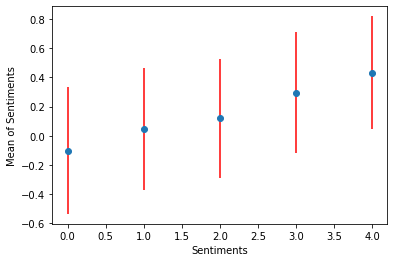

In [83]:
x = [0, 1, 2, 3, 4]
y = [s0mean, s1mean, s2mean, s3mean, s4mean]
plt.errorbar(x, y, yerr=[s0std, s1std, s2std, s3std, s4std], ecolor="Red", fmt="o")
plt.xlabel("Sentiments")
plt.ylabel("Mean of Sentiments");

The figure above shows the error bar for sentiment predictions with the sentiment vader package. There is a significant difference between the data point (blue dot) and the cap length (red line). Therefore, this shows that the sentiment vader package is not approprate for this particular dataset. 